# Gap-Stability Alpha — Vectorized Backtester

**Strategy**: Intraday mean-reversion on overnight gaps, filtered by previous-day entropy stability and Nifty regime.

**Signal**: $\alpha_t = -\dfrac{\text{Open}_t - \text{Close}_{t-1}}{\text{ATR}_{14,\,t-1}}$

Long if gap-down ($\alpha > 0$), Short if gap-up ($\alpha < 0$).

**Filters** (all lookahead-free):
| Filter | Threshold | Purpose |
|--------|-----------|---------|
| $\lvert \text{Gap} / \text{ATR}_{t-1} \rvert$ | $> 0.5$ | Minimum signal strength |
| Prev-day normalised entropy $H_{n}$ | $< 0.50$ | Prior day must show ordered price action |
| $\lvert \text{Nifty gap} / \text{ATR}_{t-1} \rvert$ | $< 1.5$ | Skip market-wide gap events |

**Ranking** (top 3 / day): $\text{score} = \lvert\alpha\rvert \times (1 - H_{n,\,t-1}) \times \text{Nifty alignment boost}$

**Entry**: 09:20 IST at bar open &nbsp;|&nbsp; **Exit**: First of — Gap fill · ATR-based stop ($2.5 \times \text{ATR}_{t-1}$) · Time exit

**Capital**: ₹1,00,000 &nbsp;|&nbsp; Max 3 trades / day &nbsp;|&nbsp; Equal-weight allocation

**Costs**: 0.05 % slippage + 0.02 % brokerage per side (0.14 % round-trip)

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import time as dtime, datetime
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 120

# ═══════════════════════════════════════════════════════════
#  Configuration — lookahead-free, sweep-optimised
# ═══════════════════════════════════════════════════════════
DATA_DIR          = Path("stocks_data")
SLIPPAGE_PCT      = 0.0005          # 0.05 % per side
BROKERAGE_PCT     = 0.0002          # 0.02 % per side
TOTAL_COST_RT     = 2 * (SLIPPAGE_PCT + BROKERAGE_PCT)  # 0.14 % RT

# ── Signal thresholds (sweep-optimised on lookahead-free data) ──
ATR_PERIOD        = 14
ENTROPY_BINS      = 10
MAX_ENTROPY_RAW   = np.log2(ENTROPY_BINS)   # ≈ 3.32
ENTROPY_THRESH    = 0.50                     # strict: very structured days only
GAP_ATR_THRESH    = 0.5                      # loose: let composite ranking sort

# ── Stop-loss ──
STOP_ATR_MULT     = 2.5                      # 2.5 × ATR_{t-1}

# ── Entry / exit ──
ENTRY_TIME        = dtime(9, 20)
ANNUALIZE_FACTOR  = 252

# ── Backtest period ──
WARMUP_START      = pd.Timestamp('2019-01-01')   # ATR/entropy lookback
BACKTEST_START    = pd.Timestamp('2020-01-01')    # first trade date

# ── Capital & position management ──
INITIAL_CAPITAL    = 100_000
MAX_TRADES_PER_DAY = 3

# ── Multi-exit comparison ──
EXIT_TIMES = {
    '09:45': dtime(9, 45),
    '10:00': dtime(10, 0),
    '11:00': dtime(11, 0),
    '12:00': dtime(12, 0),
    '15:00': dtime(15, 0),
}
DEFAULT_EXIT_KEY  = '15:00'

# ── Nifty 50 regime filters ──
NIFTY_FILE        = DATA_DIR / 'NIFTY 50_minute.csv'
NIFTY_MA_PERIOD   = 20
NIFTY_GAP_SKIP    = 1.5          # skip days with large Nifty gap
NIFTY_ALIGN_BOOST = 1.5          # rank boost for trend-aligned trades
NIFTY_ANTI_MULT   = 0.7          # rank penalty for counter-trend

# ── Discover stock files ──
EXCLUDE_FILES = {'NIFTY 50_minute.csv', 'NIFTY BANK_minute.csv'}
stock_files = sorted([
    f for f in DATA_DIR.glob('*_minute.csv')
    if f.name not in EXCLUDE_FILES
])

print(f"✓ {len(stock_files)} stocks | Period: {BACKTEST_START.date()}+ "
      f"| Capital: ₹{INITIAL_CAPITAL:,.0f} | Max {MAX_TRADES_PER_DAY} trades/day")
print(f"✓ Entropy < {ENTROPY_THRESH} | |Gap/ATR_{{t-1}}| > {GAP_ATR_THRESH}"
      f" | SL = {STOP_ATR_MULT}×ATR_{{t-1}} | Entry {ENTRY_TIME}")
print(f"✓ Nifty: skip if |gap/ATR| > {NIFTY_GAP_SKIP} | "
      f"rank boost {NIFTY_ALIGN_BOOST}× aligned / {NIFTY_ANTI_MULT}× anti")

✓ 103 stocks | Period: 2020-01-01+ | Capital: ₹100,000 | Max 3 trades/day
✓ Entropy < 0.5 | |Gap/ATR_{t-1}| > 0.5 | SL = 2.5×ATR_{t-1} | Entry 09:20:00
✓ Nifty: skip if |gap/ATR| > 1.5 | rank boost 1.5× aligned / 0.7× anti


/Users/praneshwarkk/Downloads/gap_stability alpha/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Loading

Load 1-minute OHLCV CSVs. Timestamps are already in IST (Indian Standard Time) based on NSE market hours (09:15–15:29).

In [2]:
def load_stock(filepath: Path) -> pd.DataFrame:
    """Load 1-min OHLCV CSV, filtered from WARMUP_START for lookback."""
    df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
    df = df.sort_index()
    df.columns = df.columns.str.strip().str.lower()
    df = df[df.index >= WARMUP_START]
    df['trading_date'] = df.index.date
    df['bar_time']     = df.index.time
    return df


def load_nifty_daily() -> pd.DataFrame:
    """
    Build daily Nifty 50 features — all outputs are lookahead-free.

    Returns (per trading day):
      nifty_trend   : +1 / -1  — *previous* day's close vs its MA(20)
      nifty_gap_atr : float    — today's |gap| / *previous* day's ATR

    Lookahead guards:
      • nifty_trend is shifted by 1 day so that it reflects the regime
        observable *before* the current open.
      • nifty_atr is shifted by 1 day so the denominator of gap/ATR
        only uses completed trading data.
    """
    nf = pd.read_csv(NIFTY_FILE, parse_dates=['date'], index_col='date')
    nf = nf.sort_index()
    nf.columns = nf.columns.str.strip().str.lower()
    nf = nf[nf.index >= WARMUP_START]
    nf['trading_date'] = nf.index.date

    daily = nf.groupby('trading_date').agg(
        nifty_open=('open', 'first'),
        nifty_high=('high', 'max'),
        nifty_low=('low', 'min'),
        nifty_close=('close', 'last'),
    )

    # ── Trend filter (lagged 1 day — no lookahead) ────────
    daily['nifty_ma'] = daily['nifty_close'].rolling(
        NIFTY_MA_PERIOD, min_periods=NIFTY_MA_PERIOD).mean()
    # Raw: is close_T > MA_T ?  Then shift → at open of T we see T-1's value.
    _raw_trend = np.where(daily['nifty_close'] > daily['nifty_ma'], 1, -1)
    daily['nifty_trend'] = pd.Series(
        _raw_trend, index=daily.index).shift(1)

    # ── Nifty gap / ATR (lagged ATR — no lookahead) ──────
    daily['nifty_pc']  = daily['nifty_close'].shift(1)
    daily['nifty_tr']  = np.maximum(
        daily['nifty_high'] - daily['nifty_low'],
        np.maximum(
            np.abs(daily['nifty_high'] - daily['nifty_pc']),
            np.abs(daily['nifty_low']  - daily['nifty_pc'])
        )
    )
    # .shift(1): at the open we only know ATR through yesterday
    daily['nifty_atr'] = (
        daily['nifty_tr']
        .rolling(14, min_periods=14)
        .mean()
        .shift(1)
    )
    daily['nifty_gap']     = daily['nifty_open'] - daily['nifty_pc']
    safe = daily['nifty_atr'].replace(0, np.nan)
    daily['nifty_gap_atr'] = (daily['nifty_gap'] / safe).abs()

    return daily[['nifty_trend', 'nifty_gap_atr']].dropna()

nifty_daily = load_nifty_daily()

# ── Sanity check ──
_sample = load_stock(stock_files[0])
print(f"Sample  : {stock_files[0].stem}  {_sample.shape}")
print(f"Range   : {_sample.index.min()} → {_sample.index.max()}")
bull    = (nifty_daily['nifty_trend'] == 1).sum()
bear    = (nifty_daily['nifty_trend'] == -1).sum()
big_gap = (nifty_daily['nifty_gap_atr'] > NIFTY_GAP_SKIP).sum()
print(f"Nifty   : {len(nifty_daily)} days | Bullish: {bull} | Bearish: {bear}")
print(f"Nifty   : {big_gap} big-gap days (|gap/ATR| > {NIFTY_GAP_SKIP})")
_sample.head(3)

Sample  : ABB_minute  (652023, 7)
Range   : 2019-01-01 09:15:00 → 2026-01-22 12:33:00
Nifty   : 1738 days | Bullish: 1069 | Bearish: 669
Nifty   : 18 big-gap days (|gap/ATR| > 1.5)


,open,high,low,close,volume,trading_date,bar_time
date,,,,,,,
2019-01-01 09:15:00,1043.85,1043.85,1041.50,1041.50,357,2019-01-01,09:15:00
2019-01-01 09:16:00,1041.50,1045.20,1041.50,1044.30,607,2019-01-01,09:16:00
2019-01-01 09:17:00,1044.30,1044.30,1041.65,1042.25,102,2019-01-01,09:17:00


## 2. Feature Engineering

Per stock, compute daily features from 1-min bars (all **lookahead-free**):

- **14-day ATR** — lagged by 1 day (`ATR_{t-1}`) so it only uses completed data
- **Gap & Alpha**: $\alpha = -(\text{Open}_t - \text{Close}_{t-1}) / \text{ATR}_{t-1}$
- **Normalised Shannon Entropy** of previous day's last 60 min returns: $H_n = H / \log_2(\text{bins}) \in [0, 1]$
- **Entry price** — open of the 09:20 bar

In [3]:
def compute_daily_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute daily features from 1-min bars for a single stock.

    Returns one row per trading day with:
      - OHLCV aggregates
      - 14-day ATR (shifted by 1 day to avoid lookahead)
      - Overnight gap and alpha signal
      - Normalised Shannon entropy of previous day's last 60 min
      - Entry price at ENTRY_TIME

    IMPORTANT — Lookahead-free design:
      - ATR is shifted by 1 so that day-T decisions use ATR_{T-1}
        (the last fully-observed ATR at market open).
      - Entropy is shifted by 1 (prev_entropy = yesterday's value).
      - prev_close is shifted by 1.
      - gap = Open_T - Close_{T-1}  →  both known at the open.
    """
    grp = df.groupby('trading_date')

    daily = pd.DataFrame({
        'open':   grp['open'].first(),
        'high':   grp['high'].max(),
        'low':    grp['low'].min(),
        'close':  grp['close'].last(),
        'volume': grp['volume'].sum(),
    })

    daily['prev_close'] = daily['close'].shift(1)

    # ── True Range & ATR (lagged 1 day — no lookahead) ────
    daily['tr'] = np.maximum(
        daily['high'] - daily['low'],
        np.maximum(
            np.abs(daily['high'] - daily['prev_close']),
            np.abs(daily['low']  - daily['prev_close'])
        )
    )
    # .shift(1): at the open of day T we only know ATR through T-1
    daily['atr'] = (
        daily['tr']
        .rolling(ATR_PERIOD, min_periods=ATR_PERIOD)
        .mean()
        .shift(1)
    )

    # ── Gap & Alpha (normalised by lagged ATR) ────────────
    daily['gap'] = daily['open'] - daily['prev_close']
    safe_atr = daily['atr'].replace(0, np.nan)
    daily['gap_atr_ratio'] = daily['gap'] / safe_atr
    daily['alpha']         = -daily['gap_atr_ratio']

    # ── Shannon Entropy (normalised 0→1) of last 60 bars ──
    last_60 = grp.tail(60).copy()
    last_60['ret'] = last_60.groupby('trading_date')['close'].pct_change()

    def _shannon_entropy_norm(rets):
        r = rets.dropna().values
        r = r[np.isfinite(r)]
        if len(r) < 10:
            return np.nan
        if r.max() == r.min():
            return 0.0
        try:
            counts, _ = np.histogram(r, bins=ENTROPY_BINS)
            p = counts / counts.sum()
            p = p[p > 0]
            raw_h = float(-np.sum(p * np.log2(p)))
            return raw_h / MAX_ENTROPY_RAW
        except (ValueError, FloatingPointError):
            return np.nan

    daily['entropy_norm'] = last_60.groupby('trading_date')['ret'].apply(
        _shannon_entropy_norm)
    # Shift: use *yesterday's* entropy for today's decision
    daily['prev_entropy'] = daily['entropy_norm'].shift(1)

    # ── Entry price at ENTRY_TIME ──
    bars_entry = df[df['bar_time'] == ENTRY_TIME]
    daily['entry_price'] = bars_entry.groupby('trading_date')['open'].first()

    return daily


def generate_signals(daily: pd.DataFrame,
                     nifty_df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate trading signals. All inputs are lookahead-free by construction.

    Hard filters (applied as masks):
      1. |gap / ATR_{t-1}| > GAP_ATR_THRESH       signal strength
      2. prev_entropy  < ENTROPY_THRESH            structured prev-day
      3. |Nifty gap / ATR_{t-1}| < NIFTY_GAP_SKIP  skip market-wide gaps

    Soft ranking (composite score for daily selection):
      score = |alpha| × (1 - prev_entropy) × nifty_alignment_mult

    Stop-loss: STOP_ATR_MULT × ATR_{t-1} away from entry.
    """
    backtest_mask = daily.index >= BACKTEST_START.date()
    valid = daily[backtest_mask].dropna(
        subset=['atr', 'prev_entropy', 'entry_price', 'gap_atr_ratio']
    ).copy()

    if valid.empty:
        return valid

    # ── Hard filters ──
    cond = (
        (valid['gap_atr_ratio'].abs() > GAP_ATR_THRESH) &
        (valid['prev_entropy'] < ENTROPY_THRESH)
    )
    trades = valid[cond].copy()
    if trades.empty:
        return trades

    # ── Merge Nifty daily data (already lagged inside load_nifty_daily) ──
    trades = trades.merge(nifty_df, left_index=True, right_index=True,
                          how='left')
    trades = trades.dropna(subset=['nifty_gap_atr'])

    # ── Filter: skip market-wide gap days ──
    trades = trades[trades['nifty_gap_atr'] < NIFTY_GAP_SKIP]
    if trades.empty:
        return trades

    # ── Direction ──
    trades['direction'] = np.where(trades['alpha'] > 0, 1, -1)

    # ── ATR-based stop-loss (uses lagged ATR — no lookahead) ──
    trades['sl_price'] = np.where(
        trades['direction'] == 1,
        trades['entry_price'] - STOP_ATR_MULT * trades['atr'],
        trades['entry_price'] + STOP_ATR_MULT * trades['atr']
    )

    # ── Composite score for ranking ──
    nifty_mult = np.where(
        trades['direction'] == trades['nifty_trend'].astype(int),
        NIFTY_ALIGN_BOOST,
        NIFTY_ANTI_MULT
    )
    trades['score'] = (
        trades['alpha'].abs().astype(float)
        * (1 - trades['prev_entropy'].astype(float))
        * nifty_mult
    )

    # Clean up Nifty helper columns
    trades = trades.drop(columns=['nifty_trend', 'nifty_gap_atr'],
                         errors='ignore')

    return trades

print(f"✓ Features (lookahead-free): entropy<{ENTROPY_THRESH} | "
      f"|gap/ATR_{{t-1}}|>{GAP_ATR_THRESH} | skip Nifty gap>{NIFTY_GAP_SKIP} | "
      f"SL={STOP_ATR_MULT}×ATR_{{t-1}}")

✓ Features (lookahead-free): entropy<0.5 | |gap/ATR_{t-1}|>0.5 | skip Nifty gap>1.5 | SL=2.5×ATR_{t-1}


## 3. Backtesting Engine

**Exit priority**: Stop-loss ($2.5 \times \text{ATR}_{t-1}$) → Gap-fill → Time exit

Exit times tested: 09:45, 10:00, 11:00, 12:00, 15:00

In [4]:
def find_exits_vectorized(df: pd.DataFrame, trades: pd.DataFrame,
                          exit_time: dtime = dtime(10, 0)) -> pd.DataFrame:
    """
    Vectorized exit detection with configurable exit time.
    Priority: stop-loss > gap-fill > time exit.
    """
    if trades.empty:
        return trades

    trade_dates = set(trades.index)
    mask = (
        df['trading_date'].isin(trade_dates) &
        (df['bar_time'] >= ENTRY_TIME) &
        (df['bar_time'] <= exit_time)
    )
    intra = df.loc[mask, ['open', 'high', 'low', 'close',
                          'trading_date', 'bar_time']].copy()

    if intra.empty:
        trades_out = trades.copy()
        trades_out['exit_type']  = 'no_data'
        trades_out['exit_price'] = np.nan
        trades_out['exit_time']  = pd.NaT
        return trades_out

    trade_cols = trades[['direction', 'entry_price', 'prev_close', 'sl_price']].copy()
    intra = intra.merge(trade_cols, left_on='trading_date',
                        right_index=True, how='inner')
    if intra.empty:
        trades_out = trades.copy()
        trades_out['exit_type']  = 'no_data'
        trades_out['exit_price'] = np.nan
        trades_out['exit_time']  = pd.NaT
        return trades_out

    is_long  = intra['direction'] == 1
    is_short = intra['direction'] == -1

    intra['sl_hit'] = (
        (is_long  & (intra['low']  <= intra['sl_price'])) |
        (is_short & (intra['high'] >= intra['sl_price']))
    )
    intra['gf_hit'] = (
        (is_long  & (intra['high'] >= intra['prev_close'])) |
        (is_short & (intra['low']  <= intra['prev_close']))
    )
    intra['any_exit'] = intra['sl_hit'] | intra['gf_hit']

    intra['cum_exit']      = intra.groupby('trading_date')['any_exit'].cumsum()
    intra['is_first_exit'] = (intra['cum_exit'] == 1) & intra['any_exit']

    intra['exit_type']  = 'none'
    intra['exit_price'] = np.nan

    fe = intra['is_first_exit']

    gf_only = fe & intra['gf_hit'] & ~intra['sl_hit']
    intra.loc[gf_only, 'exit_type']  = 'gap_fill'
    intra.loc[gf_only, 'exit_price'] = intra.loc[gf_only, 'prev_close']

    sl_any = fe & intra['sl_hit']
    intra.loc[sl_any, 'exit_type']  = 'stop_loss'
    intra.loc[sl_any, 'exit_price'] = intra.loc[sl_any, 'sl_price']

    early = intra.loc[fe, ['trading_date', 'exit_type', 'exit_price']].copy()
    early['exit_time'] = intra.loc[fe].index
    early = early.set_index('trading_date')

    early_dates = set(early.index)
    late_dates  = trade_dates - early_dates

    if late_dates:
        late_df = intra[intra['trading_date'].isin(late_dates)]
        if not late_df.empty:
            last_close = late_df.groupby('trading_date')['close'].last()
            last_idx   = late_df.groupby('trading_date').apply(
                lambda x: x.index[-1])
            time_exits = pd.DataFrame({
                'exit_type':  'time',
                'exit_price': last_close,
                'exit_time':  last_idx.values,
            })
        else:
            time_exits = pd.DataFrame(
                columns=['exit_type', 'exit_price', 'exit_time'])
    else:
        time_exits = pd.DataFrame(
            columns=['exit_type', 'exit_price', 'exit_time'])

    all_exits = pd.concat([early, time_exits])

    result = trades.copy()
    result['exit_type']  = all_exits.reindex(result.index)['exit_type']
    result['exit_price'] = all_exits.reindex(result.index)['exit_price']
    result['exit_time']  = all_exits.reindex(result.index)['exit_time']
    return result


def compute_trade_pnl(trades: pd.DataFrame) -> pd.DataFrame:
    """Net PnL per trade after slippage + brokerage."""
    if trades.empty:
        return trades
    t = trades.copy()
    ep = t['entry_price'].astype(float)
    xp = t['exit_price'].astype(float)
    t['raw_return_pct'] = np.where(
        t['direction'] == 1,
        (xp - ep) / ep,
        (ep - xp) / ep
    )
    t['net_return_pct'] = t['raw_return_pct'] - TOTAL_COST_RT
    t['pnl_per_share']  = np.where(
        t['direction'] == 1, xp - ep, ep - xp
    )
    t['is_win'] = t['net_return_pct'] > 0
    return t

print("✓ Backtesting engine defined (parameterized exit_time)")

✓ Backtesting engine defined (parameterized exit_time)


## 4. Run Multi-Exit Backtest

- **Phase 1**: Generate signals for all 103 stocks (entropy + gap/ATR + Nifty filters)
- **Phase 2**: Rank by composite score, select top 5 per day, equal-weight ₹1,00,000
- **Phase 3**: Simulate exits at 5 different times with ATR-based stops

In [5]:
def run_backtest():
    """
    Three-phase vectorized backtest (v2 — composite ranking):
      1. Generate filtered signals for ALL stocks (Tier 1+2 filters)
      2. Rank by composite score, pick top MAX_TRADES_PER_DAY per date
      3. Compute exits for each EXIT_TIME scenario
    Returns dict[exit_key → trade_log DataFrame]
    """
    # ── Phase 1: Signal generation ──────────────────────────
    all_signals = []
    stock_dfs   = {}
    errors      = []

    for fp in tqdm(stock_files, desc="Phase 1 · Signals"):
        name = fp.stem.replace('_minute', '')
        try:
            df    = load_stock(fp)
            daily = compute_daily_features(df)
            sigs  = generate_signals(daily, nifty_daily)
            if sigs.empty:
                continue
            sigs['stock'] = name
            all_signals.append(sigs)
            stock_dfs[name] = df
        except Exception as e:
            errors.append((name, str(e)))

    if errors:
        print(f"\n⚠ {len(errors)} stock errors: "
              f"{[e[0] for e in errors[:8]]}")
    if not all_signals:
        print("✗ No signals generated!")
        return {}

    raw = pd.concat(all_signals).reset_index()
    if 'trading_date' in raw.columns:
        raw = raw.rename(columns={'trading_date': 'trade_date'})
    elif 'index' in raw.columns:
        raw = raw.rename(columns={'index': 'trade_date'})
    print(f"  Raw signals : {len(raw):,} from {raw['stock'].nunique()} stocks")

    # ── Phase 2: Daily selection (top N by composite score) ─
    raw = raw.sort_values(['trade_date', 'score'],
                          ascending=[True, False])
    selected = raw.groupby('trade_date').head(MAX_TRADES_PER_DAY).copy()
    print(f"  After cap ({MAX_TRADES_PER_DAY}/day) : "
          f"{len(selected):,} trades, "
          f"{selected['stock'].nunique()} stocks")

    # ── Phase 3: Multi-exit computation ────────────────────
    results = {}
    for ekey, etime in tqdm(EXIT_TIMES.items(), desc="Phase 2 · Exits"):
        exit_trades = []
        for sname, stk in selected.groupby('stock'):
            df = stock_dfs[sname]
            st = stk.set_index('trade_date').drop(
                columns=['stock', 'score'], errors='ignore')
            try:
                t = find_exits_vectorized(df, st, exit_time=etime)
                t = compute_trade_pnl(t)
                t['stock'] = sname
                exit_trades.append(t)
            except Exception:
                pass

        if not exit_trades:
            continue

        res = pd.concat(exit_trades).reset_index()
        if 'trading_date' in res.columns:
            res = res.rename(columns={'trading_date': 'trade_date'})

        # ── Capital allocation ──
        tpd = res.groupby('trade_date').size().rename('n_today')
        res = res.merge(tpd, on='trade_date', how='left')
        res['capital_per_trade'] = (
            INITIAL_CAPITAL / res['n_today'].astype(float))
        res['shares'] = np.floor(
            res['capital_per_trade'] / res['entry_price'].astype(float))
        res['pnl_rupees'] = (
            res['net_return_pct'].astype(float)
            * res['capital_per_trade'].astype(float))
        results[ekey] = res

    # ── Summary table ──────────────────────────────────────
    print(f"\n{'Exit':<8} {'Trades':>7} {'Stocks':>7} "
          f"{'₹ PnL':>12} {'Win%':>7} {'Mean%':>8} {'Sharpe':>7}")
    print("─" * 62)
    for k, r in results.items():
        rt  = r['net_return_pct'].dropna().astype(float)
        wr  = float(r['is_win'].mean()) * 100
        pnl = float(r['pnl_rupees'].sum())
        mn  = float(rt.mean()) * 100
        n_yr = max((r['trade_date'].max()
                    - r['trade_date'].min()).days / 365.25, 0.01)
        tpy = len(r) / n_yr
        sr  = (float(rt.mean() / rt.std() * np.sqrt(tpy))
               if rt.std() > 0 else 0)
        tag = " ◀" if k == DEFAULT_EXIT_KEY else ""
        print(f"  {k:<6} {len(r):>7,} {r['stock'].nunique():>7} "
              f"₹{pnl:>10,.0f} {wr:>6.1f}% {mn:>7.3f}% {sr:>6.2f}{tag}")
    return results


results = run_backtest()
trade_log = results.get(DEFAULT_EXIT_KEY, pd.DataFrame())
print(f"\n✓ Primary analysis uses exit = {DEFAULT_EXIT_KEY}: "
      f"{len(trade_log):,} trades")
if not trade_log.empty:
    display(trade_log.head(10))

Phase 1 · Signals: 100%|██████████| 103/103 [01:28<00:00,  1.16it/s]


  Raw signals : 623 from 74 stocks
  After cap (3/day) : 589 trades, 69 stocks


Phase 2 · Exits: 100%|██████████| 5/5 [00:22<00:00,  4.52s/it]



Exit      Trades  Stocks        ₹ PnL    Win%    Mean%  Sharpe
──────────────────────────────────────────────────────────────
  09:45      589      69 ₹    77,746   37.4%   0.168%   1.00
  10:00      589      69 ₹    99,212   39.2%   0.240%   1.31
  11:00      589      69 ₹   168,282   40.2%   0.384%   1.84
  12:00      589      69 ₹   188,964   42.6%   0.443%   2.07
  15:00      589      69 ₹   211,746   46.0%   0.532%   2.12 ◀

✓ Primary analysis uses exit = 15:00: 589 trades


,trade_date,open,high,low,close,volume,prev_close,tr,atr,gap,...,exit_time,raw_return_pct,net_return_pct,pnl_per_share,is_win,stock,n_today,capital_per_trade,shares,pnl_rupees
0,2021-04-28,1408.1,1436.10,1362.95,1376.00,470199,1383.00,73.15,42.582143,25.10,...,2021-04-28 15:00:00,0.010532,0.009132,14.85,True,ABB,1,100000.000000,70.0,913.228838
1,2021-04-29,1405.0,1405.00,1377.00,1383.90,109035,1376.00,29.00,45.267857,29.00,...,2021-04-29 15:00:00,0.006542,0.005142,9.10,True,ABB,2,50000.000000,35.0,257.079290
2,2020-04-03,182.2,195.00,180.00,192.00,176788,191.90,15.00,18.517857,-9.70,...,2020-04-03 14:53:00,0.026478,0.025078,4.95,True,ADANIENSOL,2,50000.000000,267.0,1253.883391
3,2020-05-04,198.0,202.00,197.00,198.50,113736,206.50,9.50,7.946429,-8.50,...,2020-05-04 15:00:00,-0.000252,-0.001652,-0.05,False,ADANIENSOL,2,50000.000000,252.0,-82.623075
4,2020-06-24,253.0,254.65,242.55,254.65,2435422,242.55,12.10,10.735714,10.45,...,2020-06-24 09:50:00,0.025708,0.024308,6.40,True,ADANIENSOL,3,33333.333333,133.0,810.265783
5,2020-06-26,280.7,280.70,256.65,277.10,4043707,267.35,24.05,12.114286,13.35,...,2020-06-26 09:39:00,0.041413,0.040013,11.55,True,ADANIENSOL,3,33333.333333,119.0,1333.756424
6,2021-04-09,965.6,1023.50,952.55,971.25,2866356,1002.40,70.95,61.564286,-36.80,...,2021-04-09 10:40:00,0.046729,0.045329,44.75,True,ADANIENSOL,1,100000.000000,104.0,4532.897196
7,2021-04-19,954.9,1038.00,942.20,1007.00,1711705,991.35,95.80,64.007143,-36.45,...,2021-04-19 09:48:00,0.047606,0.046206,45.05,True,ADANIENSOL,3,33333.333333,35.0,1540.215576
8,2021-05-17,1100.0,1200.55,1100.00,1200.55,2126096,1143.40,100.55,48.442857,-43.40,...,2021-05-17 09:28:00,0.032742,0.031342,36.25,True,ADANIENSOL,1,100000.000000,90.0,3134.172425
9,2021-05-21,1444.0,1455.00,1420.30,1453.00,4124461,1389.00,66.00,60.310714,55.00,...,2021-05-21 15:00:00,-0.001583,-0.002983,-2.30,False,ADANIENSOL,1,100000.000000,68.0,-298.325876


## 5. Performance Metrics

Includes:
- **Annualized Sharpe Ratio** — risk-adjusted return
- **Max Drawdown** — worst peak-to-trough decline
- **Win Rate** — fraction of profitable trades
- **Probabilistic Sharpe Ratio (PSR)** — tests statistical significance, accounts for skewness & kurtosis to guard against overfitting
- **Profit Factor, Calmar Ratio, Avg Win/Loss**

In [6]:
def compute_metrics(tl: pd.DataFrame) -> dict:
    """Comprehensive performance metrics with ₹ capital tracking."""
    returns = tl['net_return_pct'].dropna().astype(float).values
    n = len(returns)
    if n == 0:
        return {'Total Trades': 0}

    mean_ret = np.mean(returns)
    std_ret  = np.std(returns, ddof=1) if n > 1 else 0.0

    # ── Capital-based ──
    pnl_arr       = tl['pnl_rupees'].astype(float).values
    total_pnl     = float(np.nansum(pnl_arr))
    final_capital  = INITIAL_CAPITAL + total_pnl

    # ── Time-based ──
    dates  = tl['trade_date']
    n_years = max((dates.max() - dates.min()).days / 365.25, 0.01)
    tpy     = n / n_years

    # ── CAGR ──
    cagr = (final_capital / INITIAL_CAPITAL) ** (1 / n_years) - 1

    # ── Sharpe ──
    sr_per = mean_ret / std_ret if std_ret > 0 else 0
    sr_ann = sr_per * np.sqrt(tpy)

    # ── Max Drawdown (₹ equity) ──
    equity      = INITIAL_CAPITAL + pd.Series(pnl_arr).cumsum()
    rolling_max = equity.cummax()
    dd_pct      = (equity - rolling_max) / rolling_max
    max_dd      = float(dd_pct.min())

    # ── Win Rate & Profit Factor ──
    win_rate = float(np.mean(returns > 0))
    gp = returns[returns > 0].sum()
    gl = abs(returns[returns < 0].sum())
    pf = gp / gl if gl > 0 else np.inf

    avg_win  = float(np.mean(returns[returns > 0])) if np.any(returns > 0) else 0
    avg_loss = float(np.mean(returns[returns < 0])) if np.any(returns < 0) else 0

    # ── Higher moments (manual, scipy 1.17 compat) ──
    if n > 2:
        m2 = np.mean((returns - mean_ret) ** 2)
        m3 = np.mean((returns - mean_ret) ** 3)
        m4 = np.mean((returns - mean_ret) ** 4)
        gamma3 = m3 / (m2 ** 1.5) if m2 > 0 else 0
        gamma4 = m4 / (m2 ** 2)   if m2 > 0 else 3
    else:
        gamma3, gamma4 = 0, 3

    # ── PSR ──
    denom = np.sqrt(
        1 - gamma3 * sr_per + (gamma4 - 1) / 4 * sr_per ** 2)
    psr = (norm.cdf(sr_per * np.sqrt(n - 1) / denom)
           if (denom > 0 and n > 1) else np.nan)

    calmar     = cagr / abs(max_dd) if max_dd != 0 else np.inf
    expectancy = win_rate * avg_win + (1 - win_rate) * avg_loss

    return {
        # Capital
        'Initial Capital':            f"₹{INITIAL_CAPITAL:,.0f}",
        'Final Capital':              f"₹{final_capital:,.0f}",
        'Total ₹ PnL':               f"₹{total_pnl:,.0f}",
        'CAGR':                       f"{cagr * 100:.2f}%",
        # Trade stats
        'Total Trades':               n,
        'Unique Stocks':              tl['stock'].nunique(),
        'Backtest Period':            f"{dates.min()} → {dates.max()}",
        'Trades / Year':              round(tpy, 1),
        # Returns
        'Mean Return / Trade':        f"{mean_ret * 100:.4f}%",
        'Std Dev / Trade':            f"{std_ret  * 100:.4f}%",
        'Annualized Sharpe':          round(sr_ann, 4),
        'Max Drawdown':               f"{max_dd  * 100:.2f}%",
        # Win/Loss
        'Win Rate':                   f"{win_rate * 100:.2f}%",
        'Profit Factor':              round(pf, 4),
        'Avg Win':                    f"{avg_win  * 100:.4f}%",
        'Avg Loss':                   f"{avg_loss * 100:.4f}%",
        'Expectancy / Trade':         f"{expectancy * 100:.4f}%",
        # Risk-adjusted
        'Calmar Ratio':               round(calmar, 4),
        'Skewness':                   round(gamma3, 4),
        'Kurtosis (raw)':             round(gamma4, 4),
        'PSR (vs SR*=0)':             f"{psr * 100:.2f}%" if not np.isnan(psr) else 'N/A',
        'Statistically Significant':  'Yes ✓' if (not np.isnan(psr) and psr > 0.95) else 'No ✗',
    }

if not trade_log.empty:
    metrics = compute_metrics(trade_log)
    print(f"\n{'═' * 50}")
    print(f"  GAP-STABILITY ALPHA — EXIT {DEFAULT_EXIT_KEY}")
    print(f"{'═' * 50}")
    for k, v in metrics.items():
        print(f"  {k:<28s} {v}")
    print(f"{'═' * 50}")
else:
    print("⚠ No trades to compute metrics.")


══════════════════════════════════════════════════
  GAP-STABILITY ALPHA — EXIT 15:00
══════════════════════════════════════════════════
  Initial Capital              ₹100,000
  Final Capital                ₹311,746
  Total ₹ PnL                  ₹211,746
  CAGR                         20.83%
  Total Trades                 589
  Unique Stocks                69
  Backtest Period              2020-01-02 → 2026-01-05
  Trades / Year                98.0
  Mean Return / Trade          0.5320%
  Std Dev / Trade              2.4900%
  Annualized Sharpe            2.1151
  Max Drawdown                 -7.77%
  Win Rate                     46.01%
  Profit Factor                2.024
  Avg Win                      2.2853%
  Avg Loss                     -0.9622%
  Expectancy / Trade           0.5320%
  Calmar Ratio                 2.6792
  Skewness                     0.4114
  Kurtosis (raw)               11.0115
  PSR (vs SR*=0)               100.00%
  Statistically Significant    Yes ✓
══════

## 6. Detailed Trade Log Export

Exports a CSV with all trade details: stock, date, direction, entry/exit times & prices, exit type, gap metrics, alpha, entropy, raw/net returns, and win flag.

In [7]:
def create_detailed_trade_log(tl):
    """Build export-ready trade log with capital columns."""
    cols_pick = [
        'stock', 'trade_date', 'direction', 'entry_price', 'exit_price',
        'exit_type', 'exit_time', 'gap', 'gap_atr_ratio', 'alpha',
        'atr', 'prev_entropy', 'sl_price', 'raw_return_pct',
        'net_return_pct', 'pnl_per_share', 'is_win',
        'n_today', 'capital_per_trade', 'shares', 'pnl_rupees',
    ]
    cols = [c for c in cols_pick if c in tl.columns]
    log = tl[cols].copy()

    log['direction_label'] = np.where(
        log['direction'] == 1, 'LONG', 'SHORT')

    rename = {
        'stock': 'Stock', 'trade_date': 'Trade_Date',
        'direction_label': 'Direction',
        'entry_price': 'Entry_Price', 'exit_price': 'Exit_Price',
        'exit_time': 'Exit_Time', 'exit_type': 'Exit_Type',
        'sl_price': 'Stop_Loss', 'gap': 'Gap',
        'gap_atr_ratio': 'Gap_ATR', 'alpha': 'Alpha',
        'atr': 'ATR_14', 'prev_entropy': 'Prev_Entropy_Norm',
        'raw_return_pct': 'Raw_Ret_%', 'net_return_pct': 'Net_Ret_%',
        'pnl_per_share': 'PnL/Share', 'is_win': 'Is_Win',
        'n_today': 'Trades_Today',
        'capital_per_trade': 'Capital_Alloc',
        'shares': 'Shares', 'pnl_rupees': 'PnL_₹',
    }
    log = log.rename(columns={k: v for k, v in rename.items()
                              if k in log.columns})
    for c in ['Raw_Ret_%', 'Net_Ret_%']:
        if c in log.columns:
            log[c] = (log[c] * 100).round(4)
    return log

if not trade_log.empty:
    detailed = create_detailed_trade_log(trade_log)
    csv_path = 'gap_stability_alpha_trade_log.csv'
    detailed.to_csv(csv_path, index=False)
    print(f"✓ Trade log saved → {csv_path}  ({len(detailed):,} rows)")
    display(detailed.head(8))
else:
    print("⚠ No trades to export.")

✓ Trade log saved → gap_stability_alpha_trade_log.csv  (589 rows)


,Stock,Trade_Date,direction,Entry_Price,Exit_Price,Exit_Type,Exit_Time,Gap,Gap_ATR,Alpha,...,Stop_Loss,Raw_Ret_%,Net_Ret_%,PnL/Share,Is_Win,Trades_Today,Capital_Alloc,Shares,PnL_₹,Direction
0,ABB,2021-04-28,-1,1409.95,1395.1,time,2021-04-28 15:00:00,25.10,0.589449,-0.589449,...,1516.405357,1.0532,0.9132,14.85,True,1,100000.000000,70.0,913.228838,SHORT
1,ABB,2021-04-29,-1,1391.10,1382.0,time,2021-04-29 15:00:00,29.00,0.640631,-0.640631,...,1504.269643,0.6542,0.5142,9.10,True,2,50000.000000,35.0,257.079290,SHORT
2,ADANIENSOL,2020-04-03,1,186.95,191.9,gap_fill,2020-04-03 14:53:00,-9.70,-0.523819,0.523819,...,140.655357,2.6478,2.5078,4.95,True,2,50000.000000,267.0,1253.883391,LONG
3,ADANIENSOL,2020-05-04,1,198.05,198.0,time,2020-05-04 15:00:00,-8.50,-1.069663,1.069663,...,178.183929,-0.0252,-0.1652,-0.05,False,2,50000.000000,252.0,-82.623075,LONG
4,ADANIENSOL,2020-06-24,-1,248.95,242.55,gap_fill,2020-06-24 09:50:00,10.45,0.973387,-0.973387,...,275.789286,2.5708,2.4308,6.40,True,3,33333.333333,133.0,810.265783,SHORT
5,ADANIENSOL,2020-06-26,-1,278.90,267.35,gap_fill,2020-06-26 09:39:00,13.35,1.102005,-1.102005,...,309.185714,4.1413,4.0013,11.55,True,3,33333.333333,119.0,1333.756424,SHORT
6,ADANIENSOL,2021-04-09,1,957.65,1002.4,gap_fill,2021-04-09 10:40:00,-36.80,-0.597749,0.597749,...,803.739286,4.6729,4.5329,44.75,True,1,100000.000000,104.0,4532.897196,LONG
7,ADANIENSOL,2021-04-19,1,946.30,991.35,gap_fill,2021-04-19 09:48:00,-36.45,-0.569468,0.569468,...,786.282143,4.7606,4.6206,45.05,True,3,33333.333333,35.0,1540.215576,LONG


## 📊 Exit-Time Comparison (09:45 · 10:00 · 11:00 · 12:00 · 15:00)

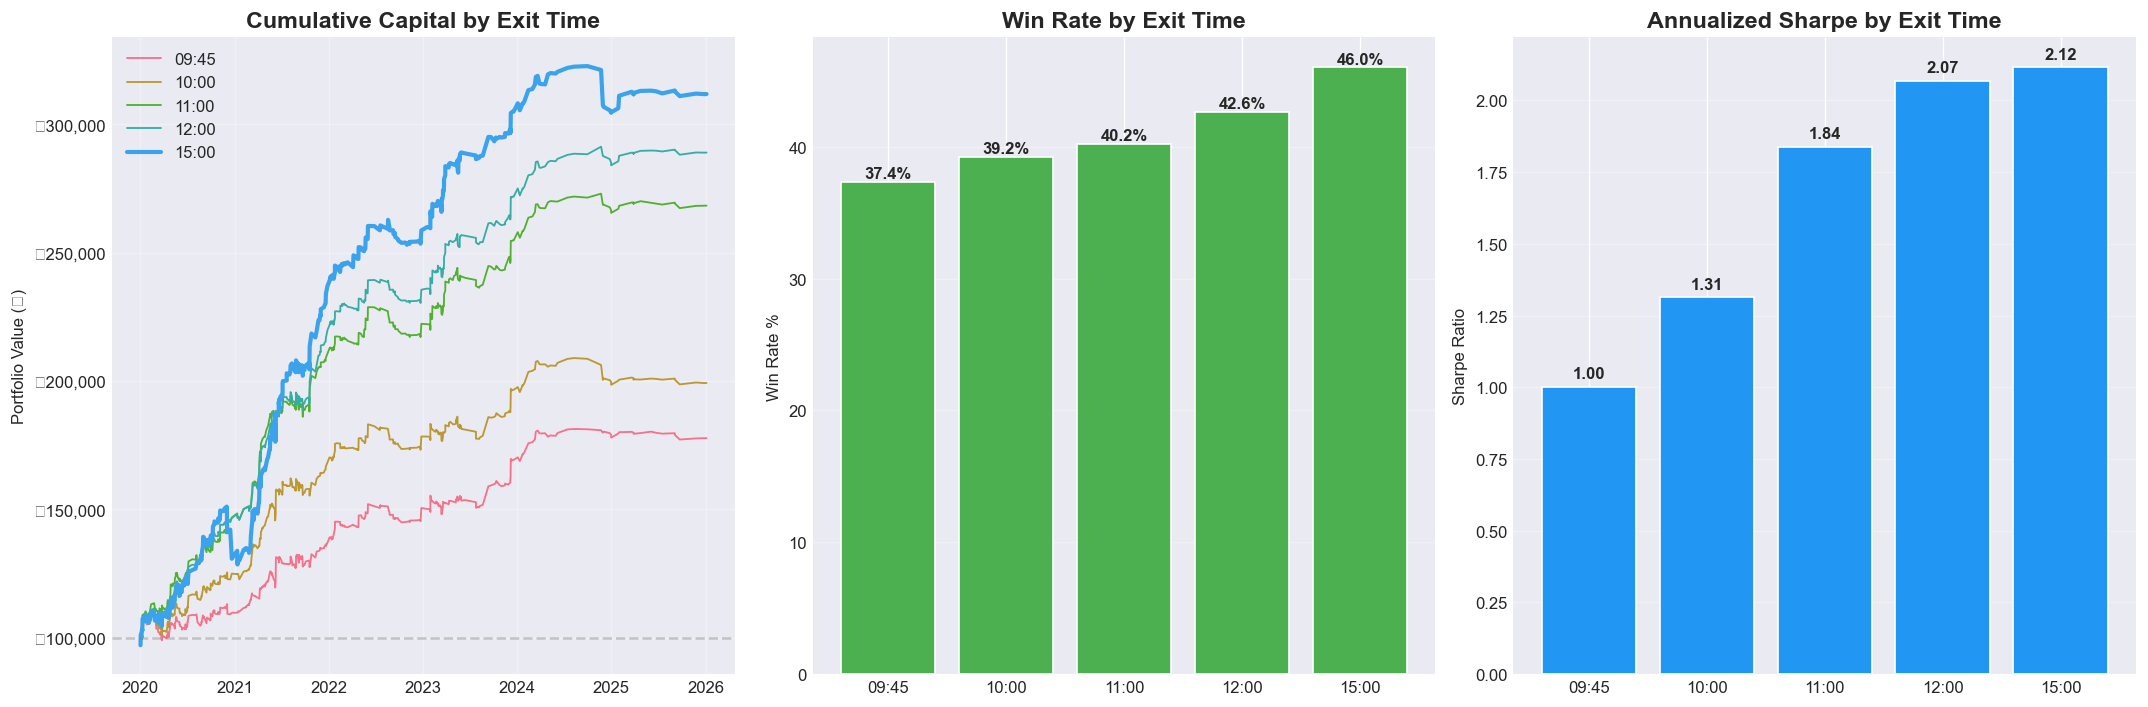


Exit          ₹ Final        ₹ PnL    Win%   MaxDD%  Sharpe
──────────────────────────────────────────────────────────
  09:45  ₹   177,746 ₹    77,746   37.4%   -8.98%   1.00
  10:00  ₹   199,212 ₹    99,212   39.2%   -8.10%   1.31
  11:00  ₹   268,282 ₹   168,282   40.2%   -5.55%   1.84
  12:00  ₹   288,964 ₹   188,964   42.6%   -6.02%   2.07
  15:00  ₹   311,746 ₹   211,746   46.0%  -14.93%   2.12 ◀


In [8]:
if len(results) < 2:
    print("⚠ Need ≥ 2 exit times to compare.")
else:
    exit_keys = list(results.keys())

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # ── 1. Cumulative ₹ capital by exit time ──
    ax = axes[0]
    for ek in exit_keys:
        r = results[ek].sort_values('trade_date').copy()
        cum = (r['pnl_rupees'].astype(float).cumsum()
               + INITIAL_CAPITAL).to_numpy(dtype=float)
        dt  = pd.to_datetime(r['trade_date'])
        lw  = 2.5 if ek == DEFAULT_EXIT_KEY else 1.1
        ax.plot(dt, cum, label=ek, lw=lw)
    ax.axhline(INITIAL_CAPITAL, color='gray', ls='--', alpha=.4)
    ax.set_title('Cumulative Capital by Exit Time',
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('Portfolio Value (₹)')
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, _: f'₹{x:,.0f}'))
    ax.legend(fontsize=10); ax.grid(True, alpha=.3)

    # ── 2. Win Rate comparison ──
    ax = axes[1]
    wrs = [float(results[k]['is_win'].mean()) * 100 for k in exit_keys]
    bars = ax.bar(exit_keys, wrs, color='#4CAF50', edgecolor='white')
    for b, w in zip(bars, wrs):
        ax.text(b.get_x() + b.get_width() / 2, w + 0.3,
                f'{w:.1f}%', ha='center', fontweight='bold', fontsize=10)
    ax.set_title('Win Rate by Exit Time',
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('Win Rate %'); ax.grid(True, alpha=.3, axis='y')

    # ── 3. Annualized Sharpe comparison ──
    ax = axes[2]
    sharpes = []
    for k in exit_keys:
        rt = results[k]['net_return_pct'].dropna().astype(float)
        ny = max((results[k]['trade_date'].max()
                  - results[k]['trade_date'].min()).days / 365.25, 0.01)
        tpy = len(rt) / ny
        sr  = (float(rt.mean() / rt.std() * np.sqrt(tpy))
               if rt.std() > 0 else 0)
        sharpes.append(sr)
    bars = ax.bar(exit_keys, sharpes, color='#2196F3', edgecolor='white')
    for b, s in zip(bars, sharpes):
        ax.text(b.get_x() + b.get_width() / 2, s + 0.03,
                f'{s:.2f}', ha='center', fontweight='bold', fontsize=10)
    ax.set_title('Annualized Sharpe by Exit Time',
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('Sharpe Ratio'); ax.grid(True, alpha=.3, axis='y')

    plt.tight_layout()
    plt.savefig('exit_time_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    # ── Summary table ──
    print(f"\n{'Exit':<8} {'₹ Final':>12} {'₹ PnL':>12} "
          f"{'Win%':>7} {'MaxDD%':>8} {'Sharpe':>7}")
    print("─" * 58)
    for i, k in enumerate(exit_keys):
        r    = results[k]
        pnl  = float(r['pnl_rupees'].sum())
        fc   = INITIAL_CAPITAL + pnl
        wr   = float(r['is_win'].mean()) * 100
        eq   = INITIAL_CAPITAL + pd.Series(
            r.sort_values('trade_date')['pnl_rupees'].astype(float).values
        ).cumsum()
        dd   = float(((eq - eq.cummax()) / eq.cummax()).min()) * 100
        sr   = sharpes[i]
        tag  = " ◀" if k == DEFAULT_EXIT_KEY else ""
        print(f"  {k:<6} ₹{fc:>10,.0f} ₹{pnl:>10,.0f} "
              f"{wr:>6.1f}% {dd:>7.2f}% {sr:>6.2f}{tag}")

## 7. Visualizations

### 7a. Equity Curve, Drawdown & Per-Trade Returns

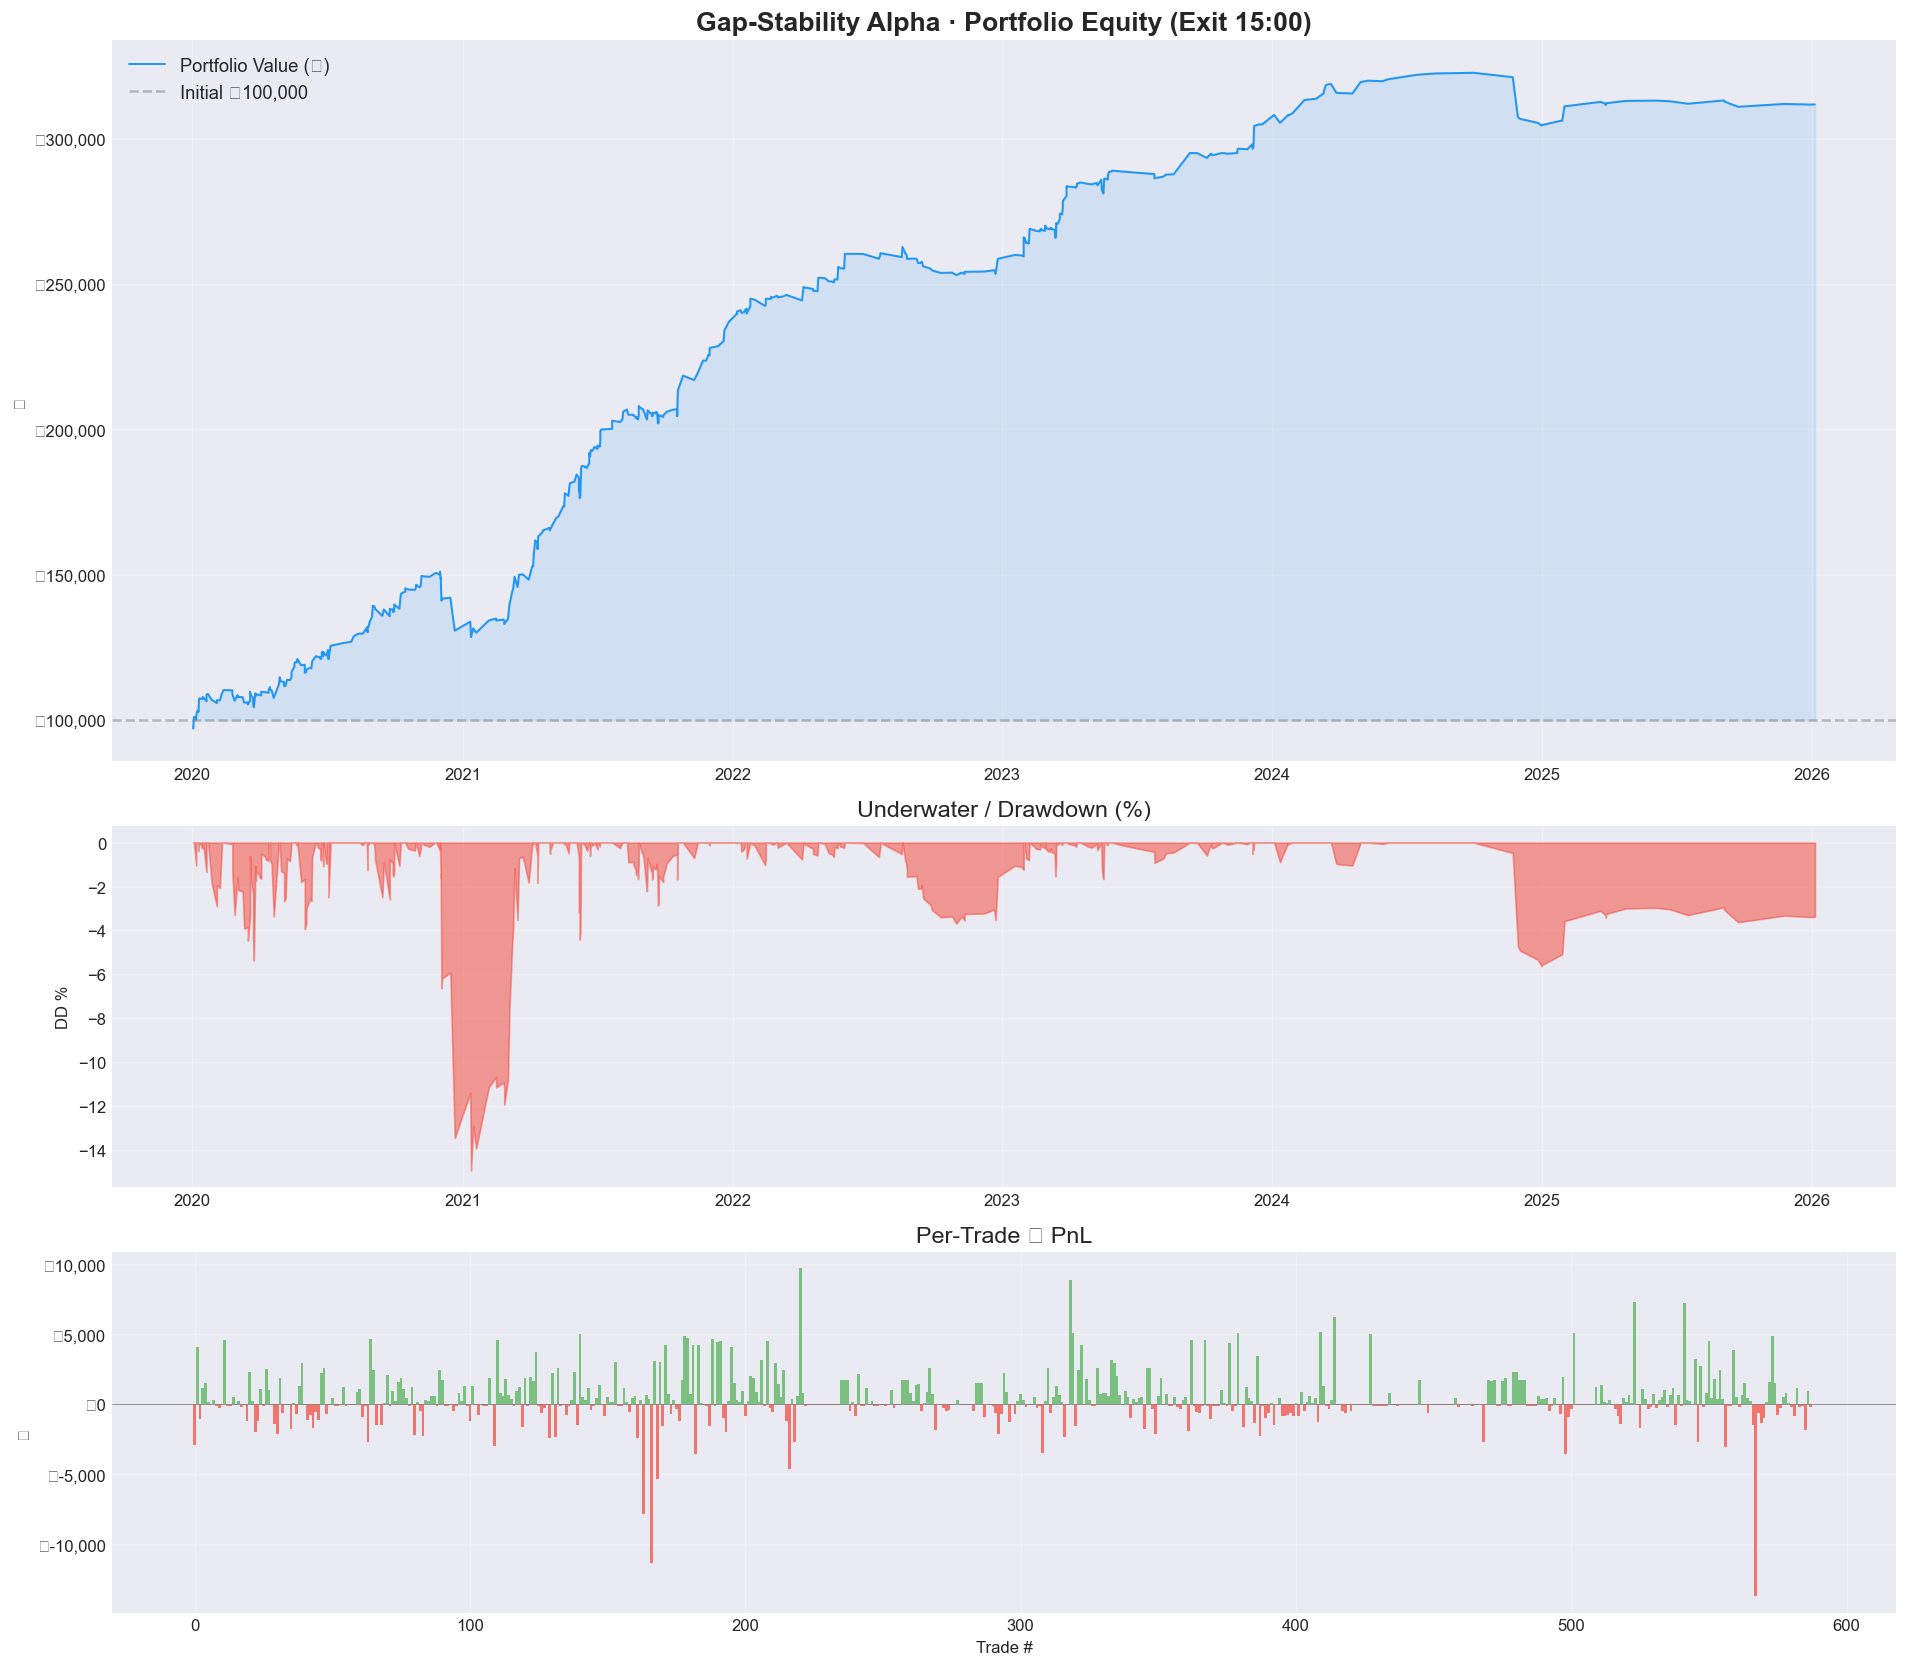

In [9]:
if trade_log.empty:
    print("⚠ No trades to plot.")
else:
    tl_s = trade_log.dropna(subset=['net_return_pct']).sort_values(
        'trade_date').reset_index(drop=True)
    dates  = pd.to_datetime(tl_s['trade_date'])
    eq_np  = (tl_s['pnl_rupees'].astype(float).cumsum()
              + INITIAL_CAPITAL).to_numpy(dtype=float)

    fig, axes = plt.subplots(3, 1, figsize=(16, 14),
                             gridspec_kw={'height_ratios': [3, 1.5, 1.5]})

    # ── Panel 1: ₹ Equity Curve ──
    ax = axes[0]
    ax.plot(dates, eq_np, color='#2196F3', lw=1.2,
            label='Portfolio Value (₹)')
    ax.axhline(INITIAL_CAPITAL, color='gray', ls='--', alpha=.5,
               label=f'Initial ₹{INITIAL_CAPITAL:,.0f}')
    ax.fill_between(dates, INITIAL_CAPITAL, eq_np,
                    alpha=.12, color='#2196F3')
    ax.set_title(f'Gap-Stability Alpha · Portfolio Equity '
                 f'(Exit {DEFAULT_EXIT_KEY})',
                 fontsize=16, fontweight='bold')
    ax.set_ylabel('₹'); ax.legend(fontsize=11)
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, _: f'₹{x:,.0f}'))
    ax.grid(True, alpha=.3)

    # ── Panel 2: Drawdown ──
    ax = axes[1]
    rm = np.maximum.accumulate(eq_np)
    dd = (eq_np - rm) / rm * 100
    ax.fill_between(dates, dd, 0, color='#F44336', alpha=.5)
    ax.set_title('Underwater / Drawdown (%)', fontsize=14)
    ax.set_ylabel('DD %'); ax.grid(True, alpha=.3)

    # ── Panel 3: Per-Trade ₹ PnL ──
    ax = axes[2]
    pnl = tl_s['pnl_rupees'].to_numpy(dtype=float)
    clr = np.where(pnl > 0, '#4CAF50', '#F44336')
    ax.bar(range(len(tl_s)), pnl, color=clr, width=1.0, alpha=.7)
    ax.axhline(0, color='gray', lw=.5)
    ax.set_title('Per-Trade ₹ PnL', fontsize=14)
    ax.set_ylabel('₹'); ax.set_xlabel('Trade #')
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, _: f'₹{x:,.0f}'))
    ax.grid(True, alpha=.3)

    plt.tight_layout()
    plt.savefig('equity_curve.png', dpi=150, bbox_inches='tight')
    plt.show()

### 7b. Monthly Returns Heatmap

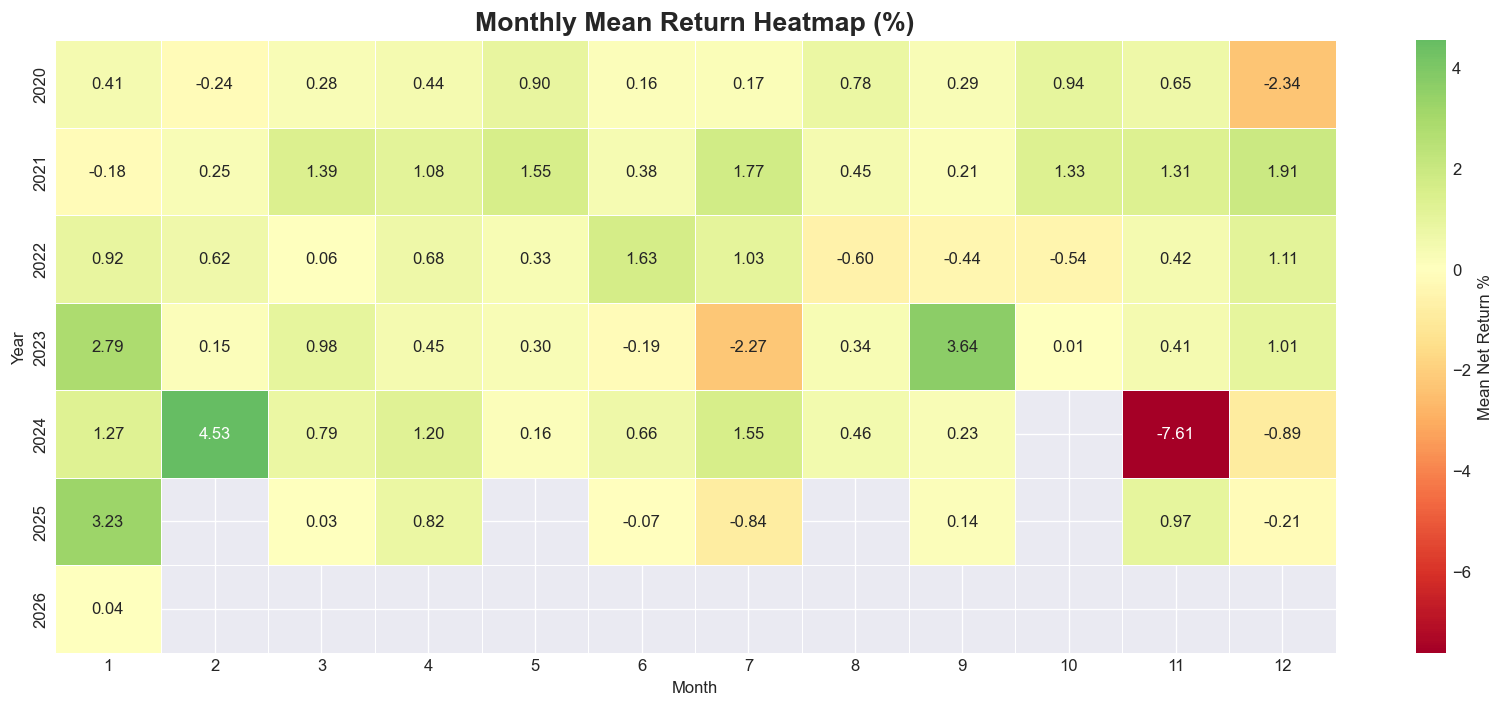

In [11]:
if trade_log.empty:
    print("⚠ No trades.")
else:
    tl_c = trade_log.copy()
    td   = pd.to_datetime(tl_c['trade_date'])
    tl_c['year']  = td.dt.year
    tl_c['month'] = td.dt.month

    pivot = tl_c.pivot_table(
        values='net_return_pct', index='year', columns='month',
        aggfunc='mean'
    ).astype(float) * 100

    fig, ax = plt.subplots(figsize=(14, 6))
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlGn',
                center=0, linewidths=.5, ax=ax,
                cbar_kws={'label': 'Mean Net Return %'})
    ax.set_title('Monthly Mean Return Heatmap (%)',
                 fontsize=16, fontweight='bold')
    ax.set_xlabel('Month'); ax.set_ylabel('Year')
    plt.tight_layout()

    plt.savefig('monthly_returns_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()

### 7c. Return Distribution & Exit Type Analysis

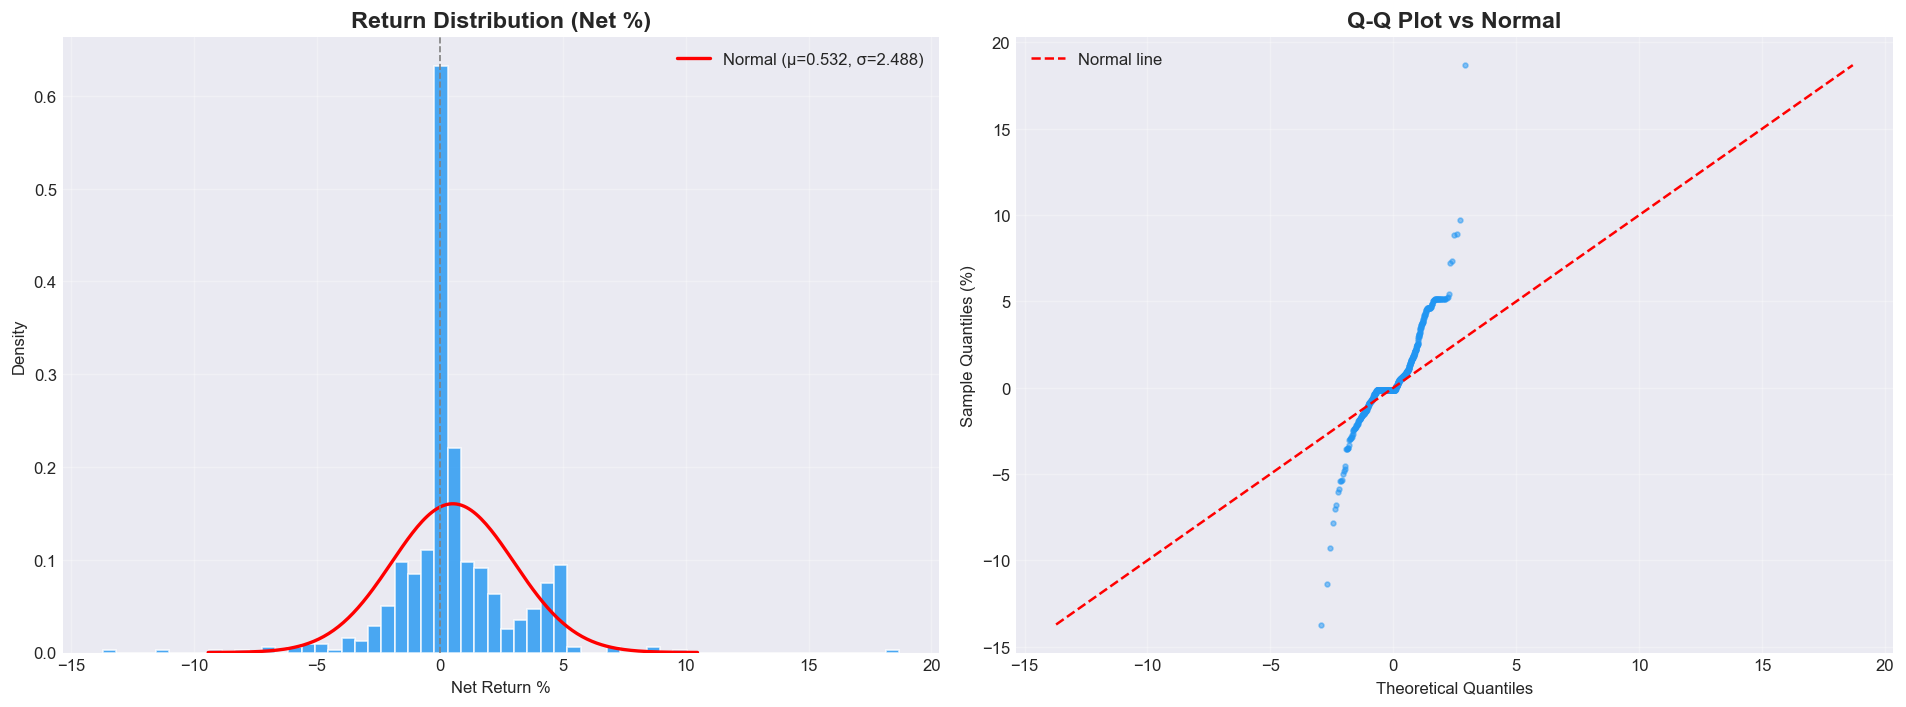

In [12]:
if trade_log.empty:
    print("⚠ No trades.")
else:
    rets = trade_log['net_return_pct'].dropna().astype(float).values

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1 — Histogram
    ax = axes[0]
    ax.hist(rets * 100, bins=60, color='#2196F3', edgecolor='white',
            alpha=.8, density=True)
    mu, sigma = np.mean(rets * 100), np.std(rets * 100)
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 200)
    ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=2,
            label=f'Normal (μ={mu:.3f}, σ={sigma:.3f})')
    ax.axvline(0, color='gray', ls='--', lw=1)
    ax.set_title('Return Distribution (Net %)',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Net Return %'); ax.set_ylabel('Density')
    ax.legend(); ax.grid(True, alpha=.3)

    # 2 — QQ plot
    ax = axes[1]
    sorted_rets = np.sort(rets)
    n = len(sorted_rets)
    theoretical = norm.ppf(np.linspace(1/(n+1), n/(n+1), n))
    ax.scatter(theoretical, sorted_rets * 100, s=8, alpha=.5,
               color='#2196F3')
    lims = [min(theoretical.min(), (sorted_rets*100).min()),
            max(theoretical.max(), (sorted_rets*100).max())]
    ax.plot(lims, lims, 'r--', lw=1.5, label='Normal line')
    ax.set_title('Q-Q Plot vs Normal',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles (%)')
    ax.legend(); ax.grid(True, alpha=.3)

    plt.tight_layout()

    plt.savefig('return_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

### 7d. Rolling Sharpe, Annual Returns & Per-Stock Performance

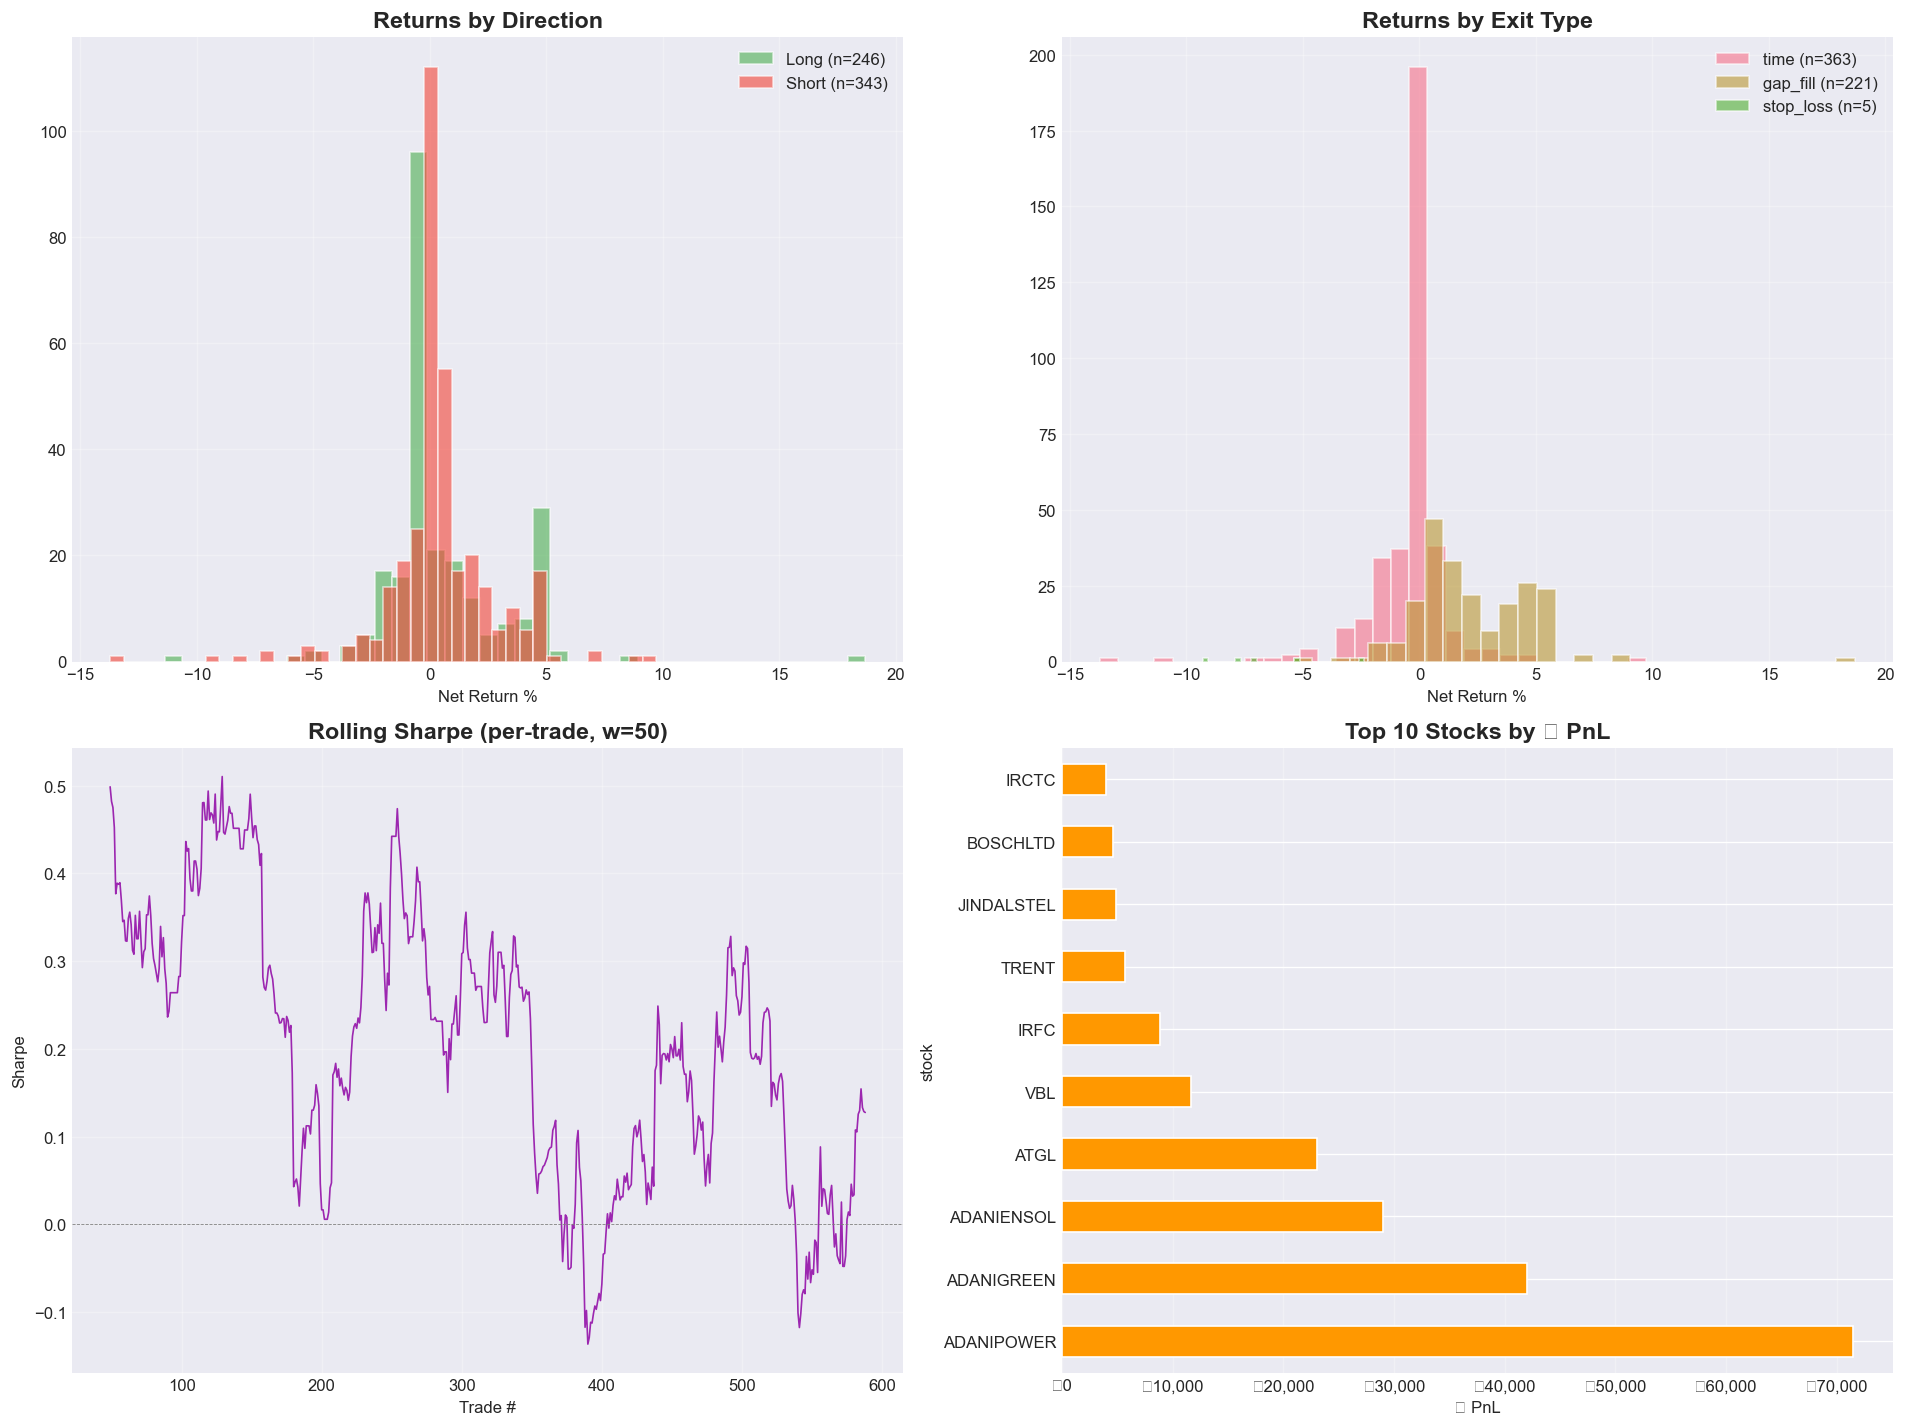

In [13]:
if trade_log.empty:
    print("⚠ No trades.")
else:
    tl_c = trade_log.copy()
    tl_c['net_f'] = tl_c['net_return_pct'].astype(float)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1 — By direction
    ax = axes[0, 0]
    for d, lbl, clr in [(1, 'Long', '#4CAF50'), (-1, 'Short', '#F44336')]:
        sub = tl_c[tl_c['direction'] == d]['net_f'] * 100
        ax.hist(sub, bins=40, alpha=.6, label=f'{lbl} (n={len(sub)})',
                color=clr, edgecolor='white')
    ax.set_title('Returns by Direction', fontsize=14, fontweight='bold')
    ax.set_xlabel('Net Return %'); ax.legend(); ax.grid(True, alpha=.3)

    # 2 — By exit type
    ax = axes[0, 1]
    for et in tl_c['exit_type'].dropna().unique():
        sub = tl_c[tl_c['exit_type'] == et]['net_f'] * 100
        ax.hist(sub, bins=30, alpha=.6, label=f'{et} (n={len(sub)})',
                edgecolor='white')
    ax.set_title('Returns by Exit Type', fontsize=14, fontweight='bold')
    ax.set_xlabel('Net Return %'); ax.legend(); ax.grid(True, alpha=.3)

    # 3 — Rolling Sharpe (50-trade window)
    ax = axes[1, 0]
    window = min(50, len(tl_c) // 3)
    if window > 5:
        rs = tl_c['net_f'].rolling(window)
        roll_sr = (rs.mean() / rs.std()).to_numpy(dtype=float)
        ax.plot(roll_sr, color='#9C27B0', lw=1)
        ax.axhline(0, color='gray', ls='--', lw=.5)
        ax.set_title(f'Rolling Sharpe (per-trade, w={window})',
                     fontsize=14, fontweight='bold')
        ax.set_xlabel('Trade #'); ax.set_ylabel('Sharpe')
    ax.grid(True, alpha=.3)

    # 4 — Cumulative by stock (top 10 ₹ PnL)
    ax = axes[1, 1]
    stk_pnl = tl_c.groupby('stock')['pnl_rupees'].sum().astype(float)
    top = stk_pnl.nlargest(10)
    top.plot.barh(ax=ax, color='#FF9800', edgecolor='white')
    ax.set_title('Top 10 Stocks by ₹ PnL', fontsize=14, fontweight='bold')
    ax.set_xlabel('₹ PnL')
    ax.xaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, _: f'₹{x:,.0f}'))
    ax.grid(True, alpha=.3, axis='x')

    plt.tight_layout()

    plt.savefig('advanced_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

### 7e. Cumulative Return by Gap Size & Entropy Heatmap

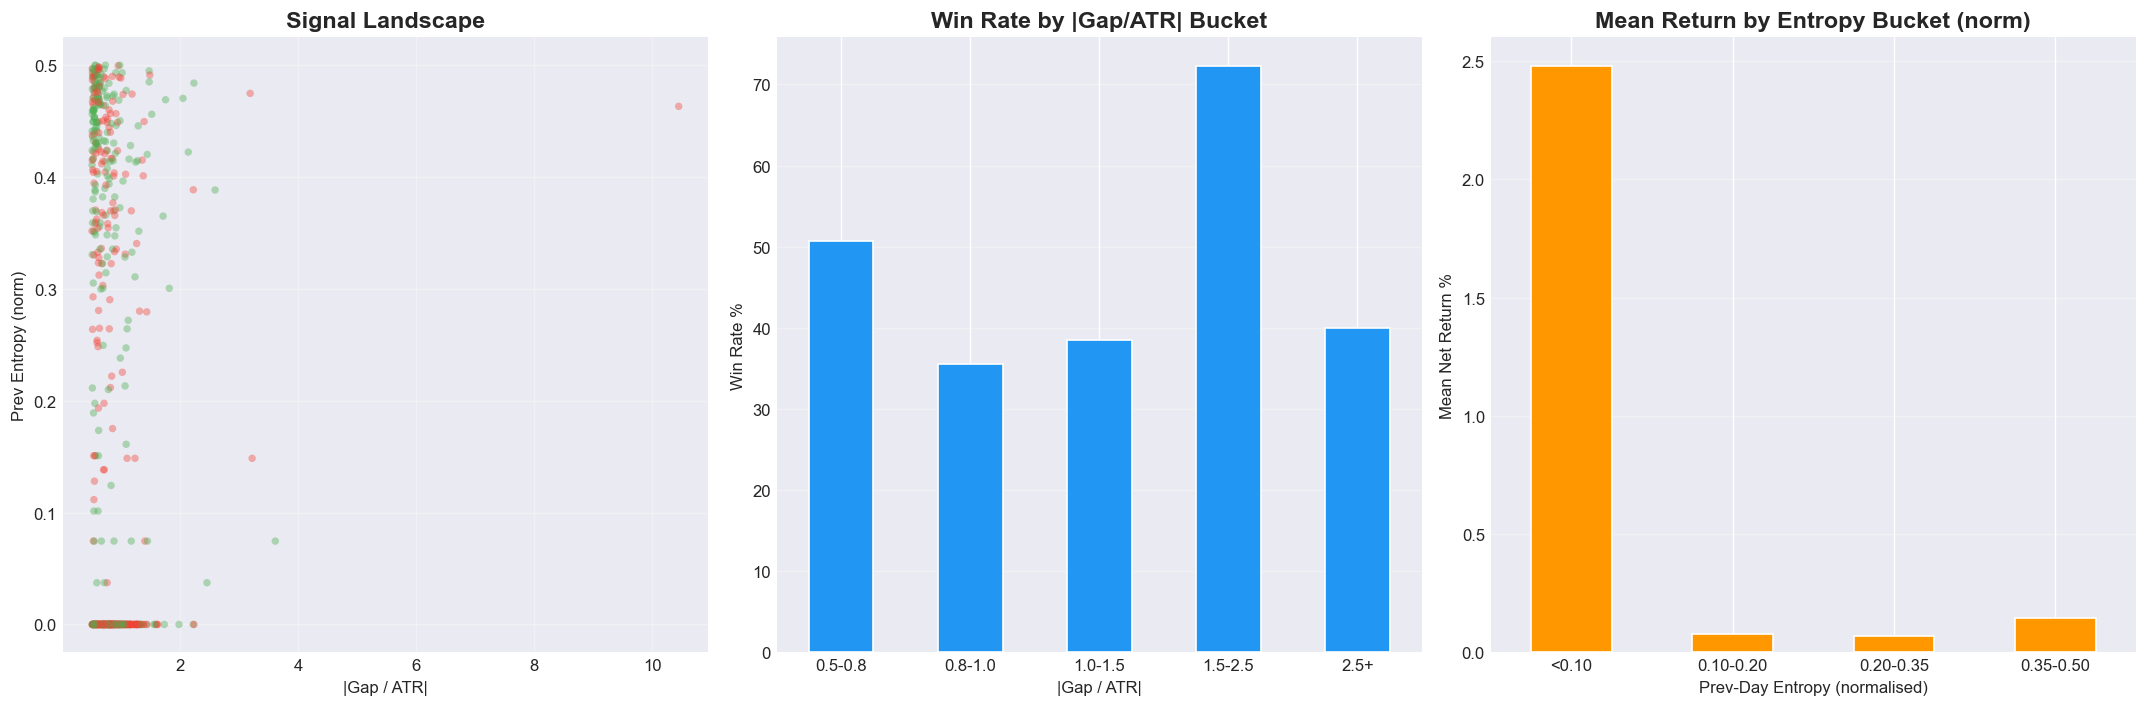

In [14]:
if trade_log.empty:
    print("⚠ No trades.")
else:
    tl_c = trade_log.copy()
    tl_c['gap_atr_abs'] = tl_c['gap_atr_ratio'].astype(float).abs()
    tl_c['entropy_f']   = tl_c['prev_entropy'].astype(float)
    tl_c['net_f']       = tl_c['net_return_pct'].astype(float)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1 — Signal landscape scatter
    ax = axes[0]
    colors = np.where(tl_c['net_f'] > 0, '#4CAF50', '#F44336')
    ax.scatter(tl_c['gap_atr_abs'], tl_c['entropy_f'],
               c=colors, alpha=.4, s=20, edgecolors='none')
    ax.set_xlabel('|Gap / ATR|'); ax.set_ylabel('Prev Entropy (norm)')
    ax.set_title('Signal Landscape', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=.3)

    # 2 — Win rate by |gap / ATR| bucket
    ax = axes[1]
    b = pd.cut(tl_c['gap_atr_abs'],
               bins=[0.5, 0.8, 1.0, 1.5, 2.5, 999],
               labels=['0.5-0.8', '0.8-1.0', '1.0-1.5', '1.5-2.5', '2.5+'])
    wr = tl_c.groupby(b, observed=True)['net_f'].apply(
        lambda x: (x > 0).mean() * 100)
    wr.plot.bar(ax=ax, color='#2196F3', edgecolor='white')
    ax.set_title('Win Rate by |Gap/ATR| Bucket',
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('Win Rate %'); ax.set_xlabel('|Gap / ATR|')
    ax.tick_params(axis='x', rotation=0); ax.grid(True, alpha=.3, axis='y')

    # 3 — Mean return by entropy bucket
    ax = axes[2]
    e_bins   = [0, 0.10, 0.20, 0.35, 0.50]
    e_labels = ['<0.10', '0.10-0.20', '0.20-0.35', '0.35-0.50']
    eb = pd.cut(tl_c['entropy_f'], bins=e_bins, labels=e_labels)
    mn = tl_c.groupby(eb, observed=True)['net_f'].mean() * 100
    mn.plot.bar(ax=ax, color='#FF9800', edgecolor='white')
    ax.set_title('Mean Return by Entropy Bucket (norm)',
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('Mean Net Return %')
    ax.set_xlabel('Prev-Day Entropy (normalised)')
    ax.tick_params(axis='x', rotation=0); ax.grid(True, alpha=.3, axis='y')

    plt.tight_layout()
    plt.savefig('gap_entropy_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()